In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
data= pd.read_csv('Folds-one sheet.csv')
num_rows= data.shape[0]
print ('Number of rows=', num_rows)

Number of rows= 47840


In [3]:
counter_nan= data.isnull().sum()
counter_without_nan= counter_nan[counter_nan==0]
data= data[counter_without_nan.keys()]

In [4]:
data.columns= ['Avg_Temp', 'Vacuum', 'Avg_Pressure', 'Humidity', 'Output']
data.head()

,Avg_Temp,Vacuum,Avg_Pressure,Humidity,Output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## For Random Forests

In [5]:
X = data[['Avg_Temp', 'Vacuum', 'Avg_Pressure', 'Humidity']].values
y = data['Output'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
rndforest= RandomForestRegressor()
rndforest.fit(X_train, y_train)

D:\conda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [8]:
y_pred = rndforest.predict(X_test)
print('R2 Score:', metrics.r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Score: 0.9992632731425197
Mean Absolute Error: 0.1626210284281235
Mean Squared Error: 0.21375685911371162
Root Mean Squared Error: 0.4623384681309913


Text(0, 0.5, 'Predictions')

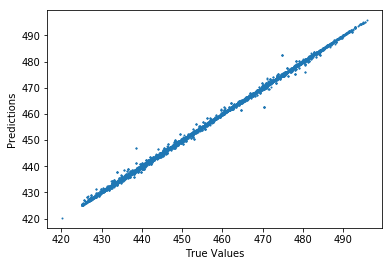

In [9]:
plt.scatter(y_test, y_pred, s=1)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [17]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
from sklearn import tree
import pydotplus

In [18]:
# Pull out one tree from the forest
tree = rndforest.estimators_[5]

In [19]:
feature_list = list(data.loc[ : , ['Avg_Temp', 'Vacuum', 'Avg_Pressure', 'Humidity'] ])
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

In [21]:
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph = pydotplus.graph_from_dot_file('tree.dot')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0617633 to fit



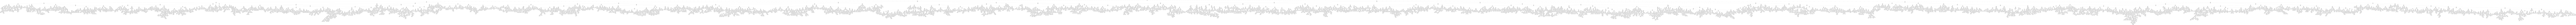

In [26]:
from IPython.display import Image  
#Write graph to a png file
Image(graph.create_png())

#Write graph to a png file
#graph.write_png('tree.png')

In [28]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]


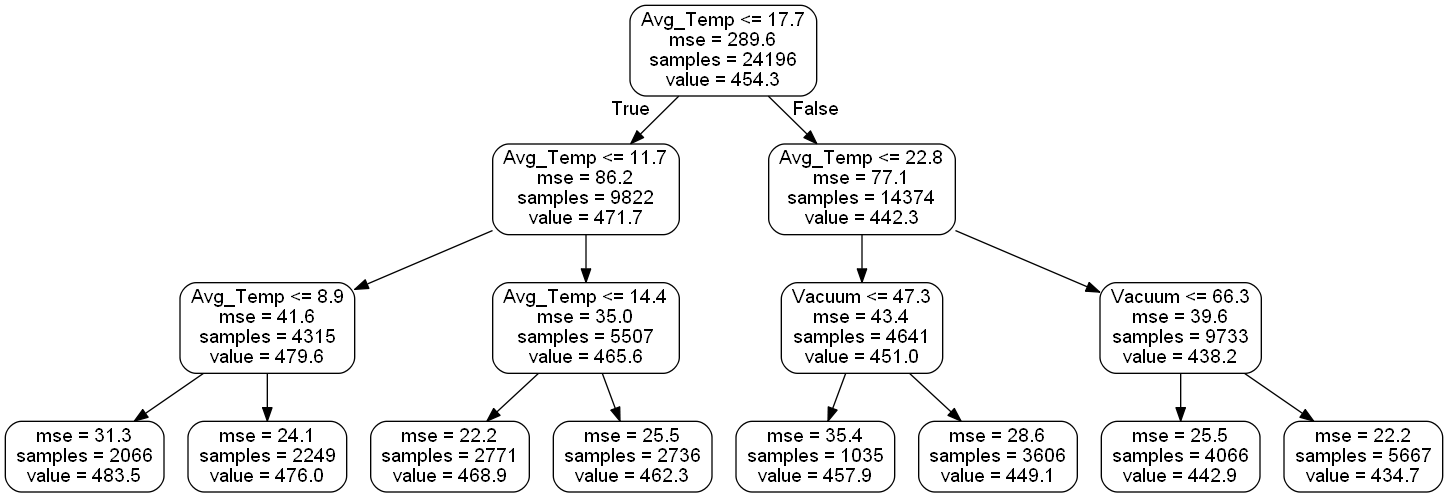

In [29]:
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

graph = pydotplus.graph_from_dot_file('small_tree.dot')
#graph.write_png('small_tree.png');
Image(graph.create_png())

## variable importance

In [36]:
# Get numerical feature importances
importances = list(rndforest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg_Temp             Importance: 0.89
Variable: Vacuum               Importance: 0.08
Variable: Avg_Pressure         Importance: 0.02
Variable: Humidity             Importance: 0.02


In [39]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Avg_Temp'), feature_list.index('Vacuum')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

In [41]:
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

In [44]:
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

#even training only with 'avg temp' and 'vacuum' gave the same accuracy

Mean Absolute Error: 0.2 degrees.
Accuracy: 99.96 %.


### Visualizations

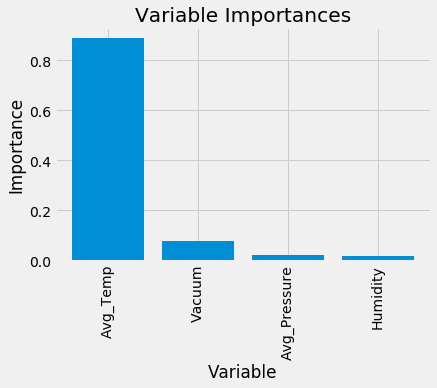

In [45]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');